# Bayesian Statistics - Final project

BUFFET Gabriel

CHENNOUFI Syrine

TAYEBJEE Meilame

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg,stats
import math
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn.linear_model import LinearRegression

## Gibbs Sampling

In [2]:
def genX(k, T, rho, n_datasets):
    """
    Generate n_datasets matrices X.

    Args:
        k: number of dimensions
        T: number of samples
        rho: correlation parameter
        n_datasets: number of datasets we want to simulate

    Returns:
        list_X: n_datasets x T x k matrix
    """

    list_X = []
    first_col = np.array([rho**i for i in range(k)])
    cov = linalg.toeplitz(first_col)

    for i in range(n_datasets):
        X = np.random.multivariate_normal(mean = np.zeros(k),cov = cov,size = T)
        X = (X-np.mean(X))/np.std(X) # we standardize the data for each dataset
        list_X.append(X)

    return np.array(list_X)

def generateData(X, s, Ry, standardize = True):
    """
    Generate the data Y given X, s and Ry.

    Args:
        X: n_datasets x T x k matrix, where T is the number of samples and k is the number of dimensions
        s: non zero coefficients of beta
        Ry: R2 coefficient

    Returns:
        Y: n_datasets x T x 1 matrix, where T is the number of samples
        beta: n_datasets x k x 1 matrix, where k is the number of dimensions
    """

    n_datasets, T, k = X.shape
    Y = np.zeros((n_datasets, T,1))
    beta = np.zeros((n_datasets, k,1))
    for i in range(n_datasets):
      nonzeros_indices = np.random.choice(range(k), size = s, replace = False).reshape((s,1))
      beta[i, nonzeros_indices, 0] = np.random.normal(size = s).reshape((s,1))
      sigma_square = ((1/Ry)-1) * np.square(np.sum(X @ beta)) / T
      Y[i, :] = X[i] @ beta[i] + np.sqrt(sigma_square) * np.random.normal(size = T).reshape((T,1))

      if standardize:
        Y[i] = (Y[i] - np.mean(Y[i])) / np.std(Y[i])


    return Y, beta

In [3]:
def create_mesh():
    """
    Creates the mesh and computes the area for each rectangle
    Args:
        None

    Returns:
        Array of the grid in the form: [x,y,area]
    """
    mesh = []
    tab = np.concatenate((np.arange(0.001,0.1,0.001),np.arange(0.1,0.9,0.01),np.arange(0.9,1,0.001)),axis = 0)
    for x in tab:
         for y in tab:
            mesh.append([x,y,area(x,y)])
    return np.array(mesh)

def area(x,y):
    """
    Computes the area for the point (x,y) of the grid

    Args:
        x: first coordinate
        y: second coordinate

    Returns:
        Area of the rectangle for the point (x,y) of the grid
    """
    dx = 0.001 if(x < 0.1 or x > 0.9) else 0.01
    dy = 0.001 if(y < 0.1 or x > 0.9) else 0.01
    return dx*dy

def compute_densityRq(mesh,Y,X,z,sigma_sq,beta):
    """
    Compute the posterior density of (R^2, q) given Y, X, z, sigma_sq, beta and a mesh

    Args:
    mesh: Array of the grid in the form: [x,y,area]
    Y: T x 1 matrix, where T is the number of samples (dataset)
    X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
    z: k x 1 matrix, where k is the number of dimensions, current estimator of z
    sigma_sq: float, current estimator of sigma^2
    beta: k x 1 matrix, where k is the number of dimensions, current estimator of beta

    Return
    matrix, the posterior density of (R^2, q) given Y, X, z, sigma_sq, beta
    """
    T, k = X.shape  
    s_z = np.sum(z)
    vx_bar = np.mean(np.var(X, axis = 0))
    log_pdf = -1/(2*sigma_sq) * (( k* vx_bar * mesh[:,1] * (1-mesh[:,0]) )/ mesh[:,0]) * float(beta.T @ np.diag(z) @ beta)
    #print(mesh[:,0],sigma_sq)
    log_pdf = log_pdf + ( s_z + 0.5*s_z)*np.log(mesh[:,1])
    #print(log_pdf)
    log_pdf = log_pdf + np.log(1-mesh[:,1])*( k - s_z )
    #print(log_pdf)
    log_pdf = log_pdf + np.log(mesh[:,0])*(- 0.5*s_z)
    #print(log_pdf)
    log_pdf = log_pdf +  np.log(1-mesh[:,0])*(0.5*s_z)
    #print(log_pdf)

    cdf = np.exp(log_pdf) * mesh[:,2]
    #print(log_pdf)
    return cdf/np.sum(cdf)

In [4]:
def compute_Tilde(Y,X,R_sq,q,z,vx_bar, gamma_sq):
    """
    Computes the estimator of (X'X+I/gamma^2), its inverse and beta_tilde
    Args:
        Y: T x 1 matrix, where T is the number of samples (dataset)
        X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
        R_sq: float, current estimator of R^2
        q: float, current estimator of q
        z: k x 1 matrix, where k is the number of dimensions, current estimator of z
        vx_bar: the mean of the variance of X
        gamma_sq: float, current estimator of gamma^2

    Returns:
        W_tilde: k x k matrix, where k is the number of dimensions, current estimator of X'X+I/gamma^2
        inv_W_tilde: k x k matrix, where k is the number of dimensions, current estimator of (X'X+I/gamma^2)^-1
        beta_tilde: k x 1 matrix, where k is the number of dimensions, current estimator of beta
    """
    sz = np.sum(z)
    X_tilde = X[:,z==1]
    W_tilde = X_tilde.T @ X_tilde + (1/gamma_sq) * np.eye(sz)
    inv_W_tilde = np.linalg.inv(W_tilde)
    beta_tilde = inv_W_tilde @ X_tilde.T @ Y
    return W_tilde, inv_W_tilde, beta_tilde

In [5]:
def sampleCondPostZi(Y,X,R_sq,q,other_z, i):
  """
  Samples zi|other_z, Y, X, R^2, q

  Args:
    Y: T x 1 matrix, where T is the number of samples (dataset)
    X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
    R_sq: float, current estimator of R^2
    q: float, current estimator of q
    other_z: k-1 x 1 matrix, where k is the number of dimensions
    i: int, the zi we want to sample

  Return
    int {0,1}, sampled zi|other_z, Y, X, R^2, q
  """
  T, k = X.shape
  vx_bar = np.mean(np.var(X, axis = 0))
  gamma_sq = 1/ (( k* vx_bar * q * (1-R_sq) )/ R_sq)

  #Computation of P(zi=1|other_z, Y, X, R^2, q)
  considered_z_1 = np.insert(other_z, i, 1) #Insert 1 in the ith position
  s = np.sum(considered_z_1)
  W_tilde_1, inv_W_tilde_1, beta_tilde_1 = compute_Tilde(Y,X,R_sq,q,considered_z_1,vx_bar, gamma_sq)
  logproba_of_1 = s*(np.log(q) - np.log(1-q)) -0.5*s*np.log(gamma_sq) - 0.5*np.log(np.linalg.det(W_tilde_1)) - 0.5*T*np.log(0.5*(Y.T@Y - beta_tilde_1.T@W_tilde_1@beta_tilde_1))


  #Computation of P(zi=0|other_z, Y, X, R^2, q)
  considered_z_0 = np.insert(other_z, i, 0) #Insert 0 in the ith position
  s = np.sum(considered_z_0)
  W_tilde_0, inv_W_tilde_0, beta_tilde_0 = compute_Tilde(Y,X,R_sq,q,considered_z_0,vx_bar, gamma_sq)
  logproba_of_0 = s*(np.log(q) - np.log(1-q)) -0.5*s*np.log(gamma_sq)  - 0.5*np.log(np.linalg.det(W_tilde_0)) - 0.5*T*np.log(0.5*(Y.T@Y - beta_tilde_0.T@W_tilde_0@beta_tilde_0))

  #Normalization

  logprobas = np.array([logproba_of_0, logproba_of_1])
  logprobas -= np.max(logprobas)
  probas = np.exp(logprobas)
  probas /= np.sum(probas)
  u = np.random.uniform()
  if u < probas[0]:
      return 0
  else:
      return 1

def draw_z(Y,X,R_sq,q, current_z, n_iterations = 1):
    """
    Draws z using a Gibbs sampler
    Args:
        Y: T x 1 matrix, where T is the number of samples (dataset)
        X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
        R_sq: float, current estimator of R^2
        q: float, current estimator of q
        current_z: k x 1 matrix, where k is the number of dimensions, current estimator of z
        n_iterations: int, number of iterations

    Returns:
        z: k x 1 matrix, where k is the number of dimensions, new estimator of z
    """
    T, k = X.shape
    for t in range(n_iterations):
      for i in range(k):
          other_z = np.delete(current_z,i)
          current_z[i]= sampleCondPostZi(Y,X,R_sq,q,other_z, i)

    return current_z

In [6]:
def draw_sigma_sq(Y,X,R_sq,q,z,beta_tilde,W_tilde):
    """
    Draws sigma_sq given Y, X, R_sq, q, z, Mat
    Args:
        Y: T x 1 matrix, where T is the number of samples (dataset)
        X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
        R_sq: float, the R2 in which we want to compute the density
        q: float, the q in which we want to compute the density
        z: k x 1 matrix, where k is the number of dimensions, current estimator of z
        beta_tilde: k x 1 matrix, where k is the number of dimensions, current estimator of "the non-zeros beta"
        W_tilde: k x k matrix, where k is the number of dimensions, current estimator of X'X+I/gamma^2

    Returns:
        sigma_sq: float, current estimator of sigma^2
    """
    T, k = X.shape
    par_1 = T/2
    par_2 = (Y.T @ Y - beta_tilde.T @ W_tilde @ beta_tilde)/2
    sigma_sq = stats.invgamma.rvs(a = par_1,scale = par_2, size = 1)
    return sigma_sq

def draw_beta_tilde(Y,X,R_sq,q,z,sigma_sq,inv_W_tilde):
    """
    Draws beta_tilde given Y, X, R_sq, q, z, sigma_sq, Mat
    Args:
        Y: T x 1 matrix, where T is the number of samples (dataset)
        X: T x k matrix, where T is the number of samples and k is the number of dimensions (dataset)
        R_sq: float, the R2 in which we want to compute the density
        q: float, the q in which we want to compute the density
        z: k x 1 matrix, where k is the number of dimensions, current estimator of z
        sigma_sq: float, current estimator of sigma^2
        inv_W_tilde: k x k matrix, where k is the number of dimensions, current estimator of (X'X+I/gamma^2)^-1

    Returns:
        beta: k x 1 matrix, where k is the number of dimensions, new estimator of "the non-zeros beta" sampled from a N(0, (X'X+I/gamma^2)^-1)
    """
    X_tilde = X[:,z==1]
    par_1 = (inv_W_tilde @ X_tilde.T @ Y).reshape(-1,)
    par_2 = sigma_sq * inv_W_tilde
    beta = np.random.multivariate_normal(par_1, par_2)
    return beta

In [7]:
def run(l_X, l_Y, mesh, n_iterations, n_burning, verbose = False, histogram = False):
  """
  Runs the Gibbs sampler

  Args:
    l_X: features, n_datasets x T x k matrix, where n_datasets is the number of datasets, T is the number of samples and k is the number of dimensions (cf genX)
    l_Y: labels, n_datasets x T x 1 matrix, where n_datasets is the number of datasets, T is the number of samples (cf generateData)
    beta_init: k x 1 matrix, where k is the number of dimensions
    sigma_sq_init: float
    mesh: the mesh associated to the discretization of [0,1]x[0,1], used to sample (R2,q)
    n_iterations: int, number of total iterations
    n_burning: int, number of discarded iterations

  Returns:
    beta: k x 1 matrix, where k is the number of dimensions : Estimator of beta
    q_median: float : Estimator of q

  """
  betas=[]
  n,T,k=l_X.shape
  q_median = [0]*n
  for i in range(n):
      l_q = []
      X = l_X[i]
      Y = l_Y[i, :, :]
      vx_bar = np.mean(np.var(X, axis = 0))
      #Initialization of our estimators
      beta = Lasso(alpha = 0.01).fit(X, Y).coef_ #Attention à bien calibrer le paramètre alpha, faut qu'il y ait à peu près 1O-15 "1" dans le z initial
    
      sigma_sq = np.var(Y-X@beta)
      z = (beta != 0).reshape((k, )).astype(int)
      print("dataset {} :".format(i))
      if verbose:
        print("z initial : ", z)
        print("Number of non zeros in z : ", np.sum(z))
      for iter in tqdm(range(n_burning+n_iterations)):
        if verbose:
          print("Dataset {} iteration {}".format(i,iter))

        #Step 1: Draw (R^2, q)
        probs = compute_densityRq(mesh,Y,X,z,sigma_sq,beta)

        choose_index = np.random.choice(len(mesh), 1, p=probs)
        R_sq, q, _ = mesh[choose_index][0]

        #Step 2: Draw z
        z = draw_z(Y,X,R_sq,q, z, n_iterations = 1)


        #Step 3: Draw sigma^2
        gamma_sq = 1/ (( k* vx_bar * q * (1-R_sq) )/ R_sq)
        W_tilde, inv_W_tilde, beta_tilde = compute_Tilde(Y,X,R_sq,q,z,vx_bar, gamma_sq)

        sigma_sq = draw_sigma_sq(Y,X,R_sq,q,z,beta_tilde,W_tilde)

        #Step 4: Draw non zeros beta
        beta_tilde = draw_beta_tilde(Y,X,R_sq,q,z,sigma_sq,inv_W_tilde)

        #Step 4.5: Reconstruct beta from beta tilde and z
        beta = np.zeros((k, ))
        beta[z==1] = beta_tilde
        betas.append(beta)

        if iter>n_burning:
          l_q.append(q)
      ### Computing the median of q
      q_median[i] = np.median(l_q)

      return betas,l_q


sigma_sq_init = 1
mesh = create_mesh()

## Macro2 Dataset

In [8]:
# The different preprocessing methods
scaler=StandardScaler()
minmax=MinMaxScaler()
normalizer=Normalizer()

In [9]:
#Note: you may need to install openpyxl using pip install openpyxl
data=pd.read_excel('macro_dataset.xlsx')
data = data.dropna(axis=0,how='any')
y=data['Outcome'].values.reshape(1,91,1)
X=data.drop(['Outcome'],axis=1).values.reshape(1,91,61)

In [10]:
# Gibbs Sampling parameters
n_iterations=10000
n_burnin=n_iterations//10
n_datasets=1

In [11]:
# Select significant coefficients
def select_variables(betas, threshold = 0.05):
    selected_variables = []
    for i in range(betas.shape[1]):
        lb=np.quantile(betas[:, i], threshold)
        ub=np.quantile(betas[:, i], 1-threshold)
        if not (lb <= 0 and 0 <= ub):
            selected_variables.append(i)
    return selected_variables

In [12]:
def plotAll(betas, num_rows =20, figsize = (30, 40), indexes = None, threshold = 0.05):
    # Assuming betas is a 2D NumPy array
    num_plots = betas.shape[1]
    num_cols = int(np.ceil(num_plots / num_rows))
    indexes = range(1, num_plots + 1) if indexes is None else indexes

    # You can modify the figsize parameter to control the overall size of the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    if num_rows == 1:
        axes = axes.reshape(1, -1)
    if num_cols == 1:
        axes = axes.reshape(-1, 1)
    
    medians = []
    means = []
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_plots:
                mean = np.mean(betas[:, index])
                median = np.median(betas[:, index])
                means.append(mean)
                medians.append(median)

                axes[i, j].axvline(mean, color='r', linestyle='dashed', linewidth=2)
                axes[i, j].axvline(median, color='g', linestyle='dashed', linewidth=2)
                axes[i,j].axvspan(np.quantile(betas[:, index], threshold),
                    np.quantile(betas[:, index], 1 - threshold),
                    alpha=0.1,color='r')
                axes[i, j].hist(betas[:, index], bins=50)
                axes[i, j].set_title(r"$\beta_{{{}}}$".format(indexes[index]))  # Adding 1 to index for proper subscript
                axes[i, j].grid(True)
            else:
                # If there are more subplots than needed, hide the empty subplots
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    return medians, means

### Standard scaler

dataset 0 :


100%|██████████| 11000/11000 [11:17<00:00, 16.24it/s]


Shape of betas:  (10000, 61)


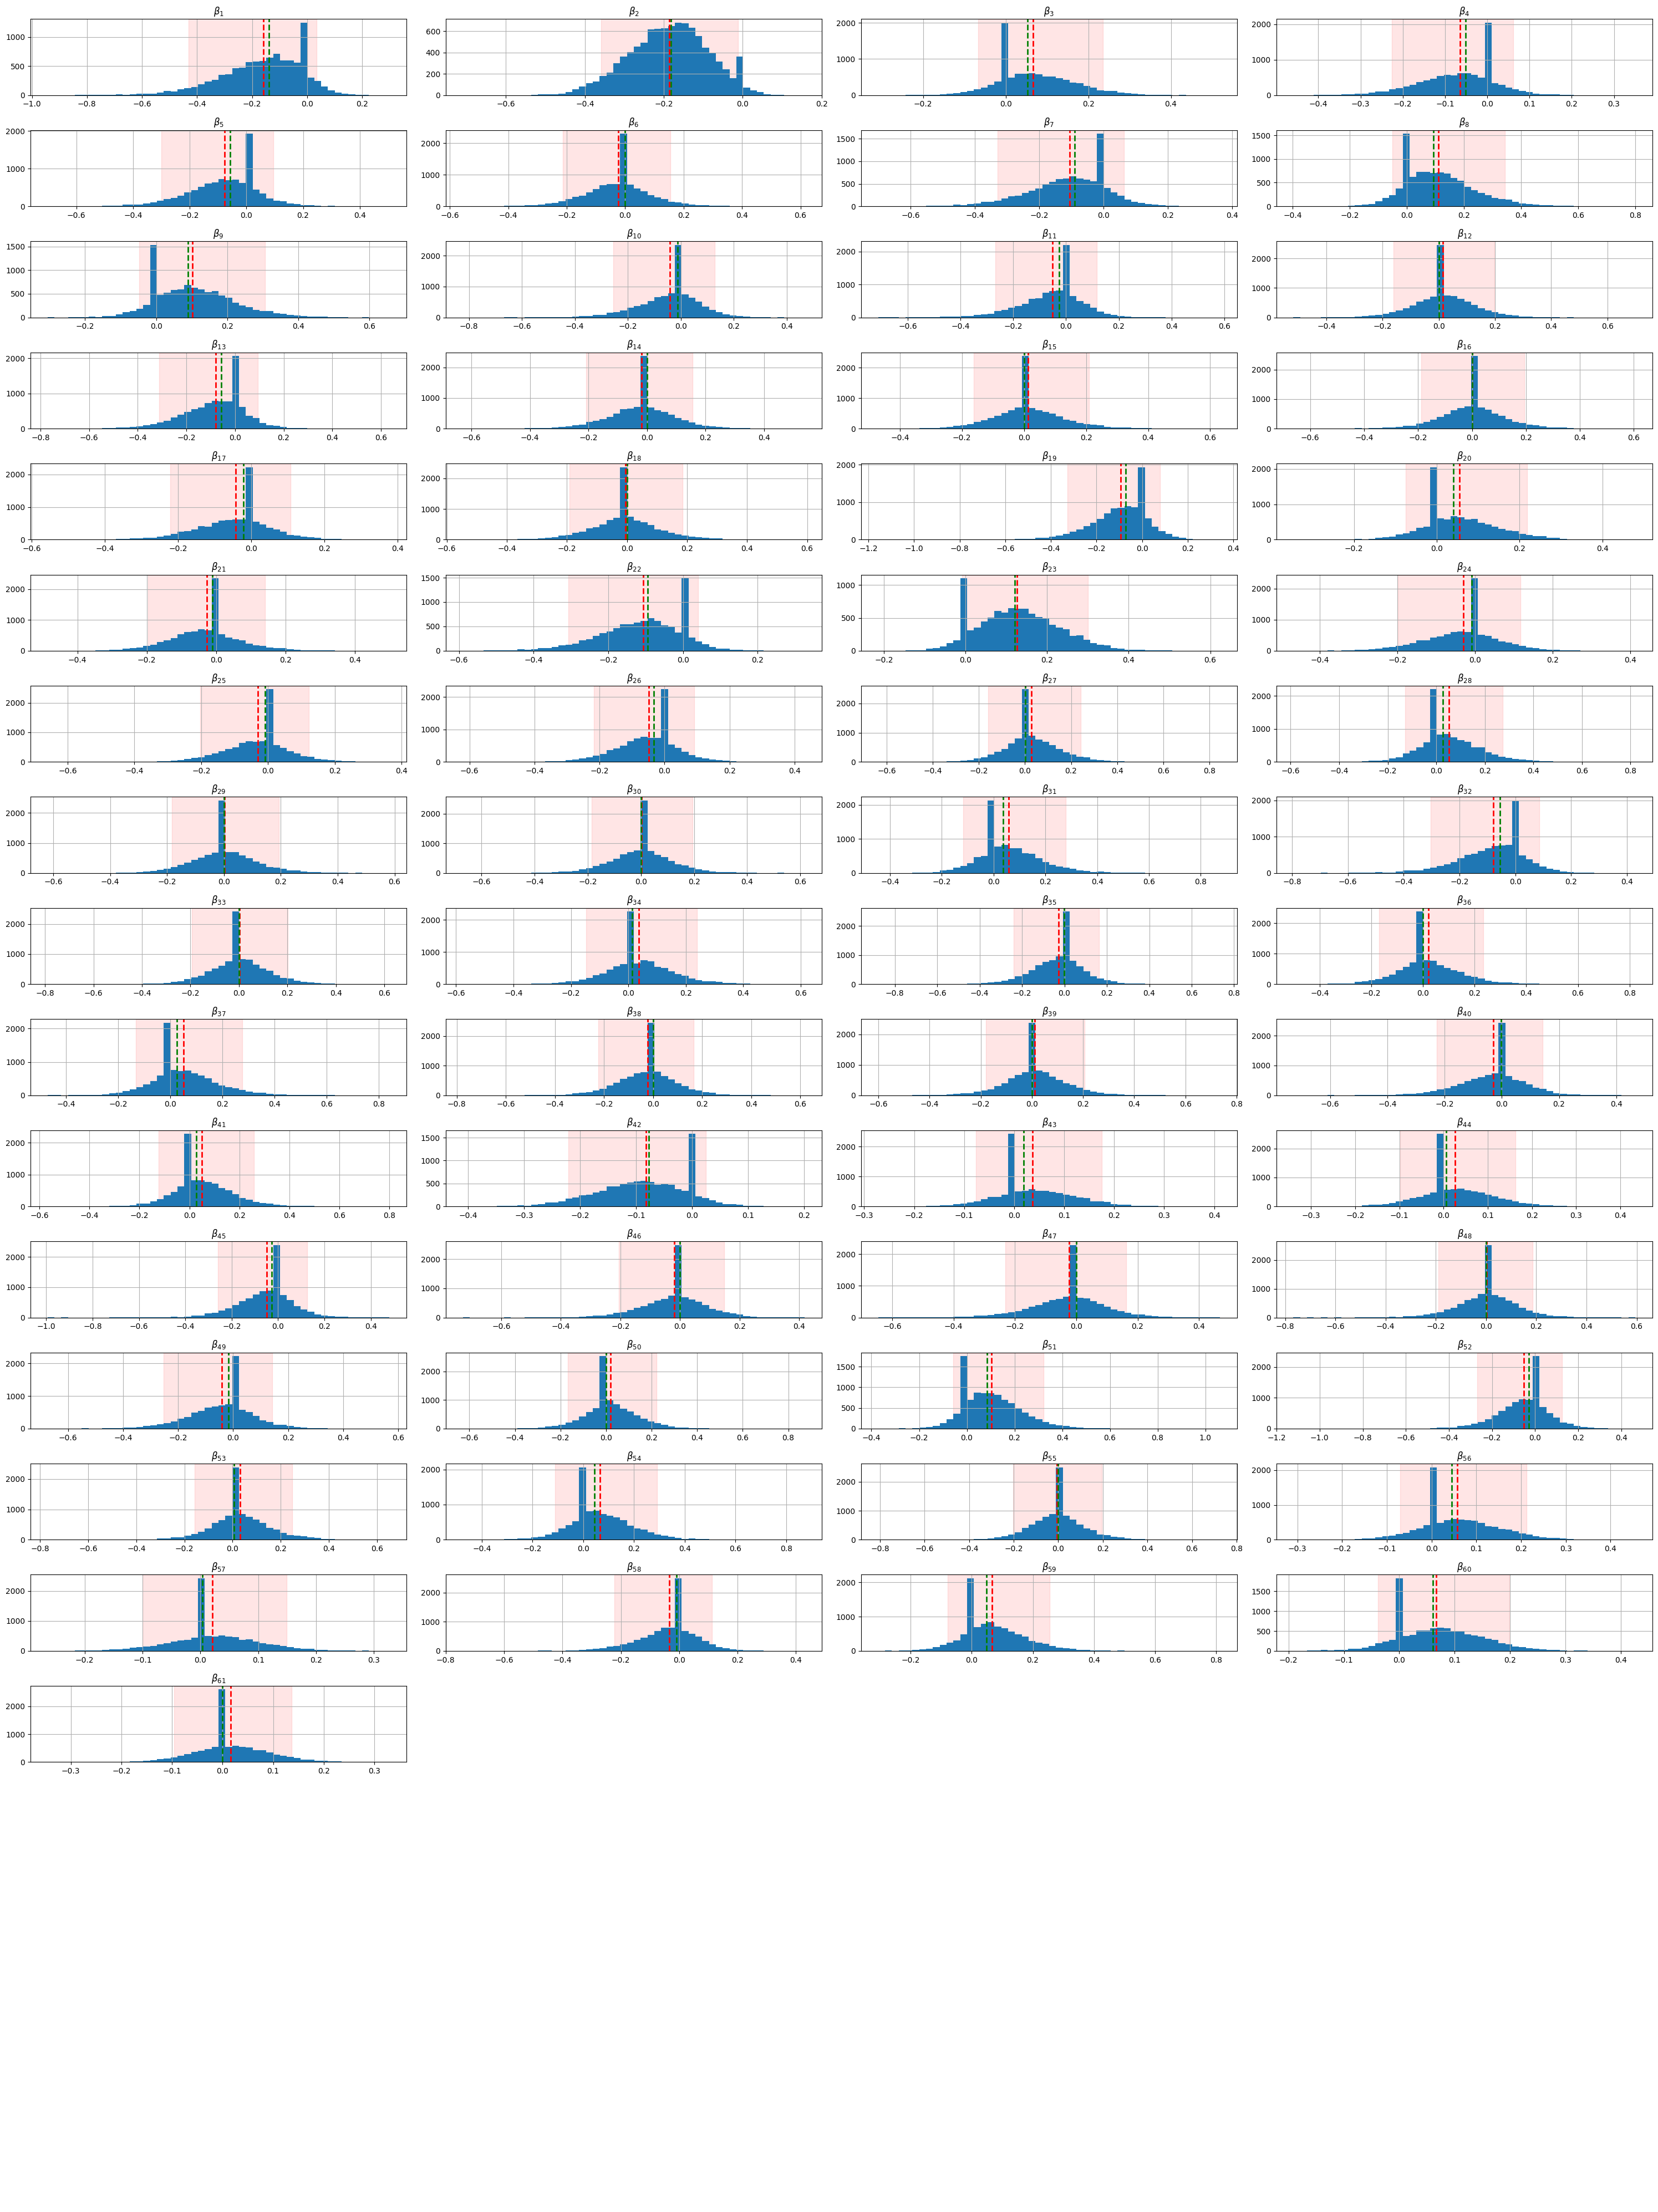

In [59]:
X_scaled=scaler.fit_transform(X[0]).reshape(1,91,61)
y_scaled=(y-np.mean(y))/np.std(y)
betas,l_q=run(X_scaled, y_scaled, mesh, n_iterations, n_burnin, verbose = False)
betas_scaled = np.array(betas[n_burnin:])
print("Shape of betas: ", betas_scaled.shape) #Expected (10000, 61)
medians, means = plotAll(betas_scaled)


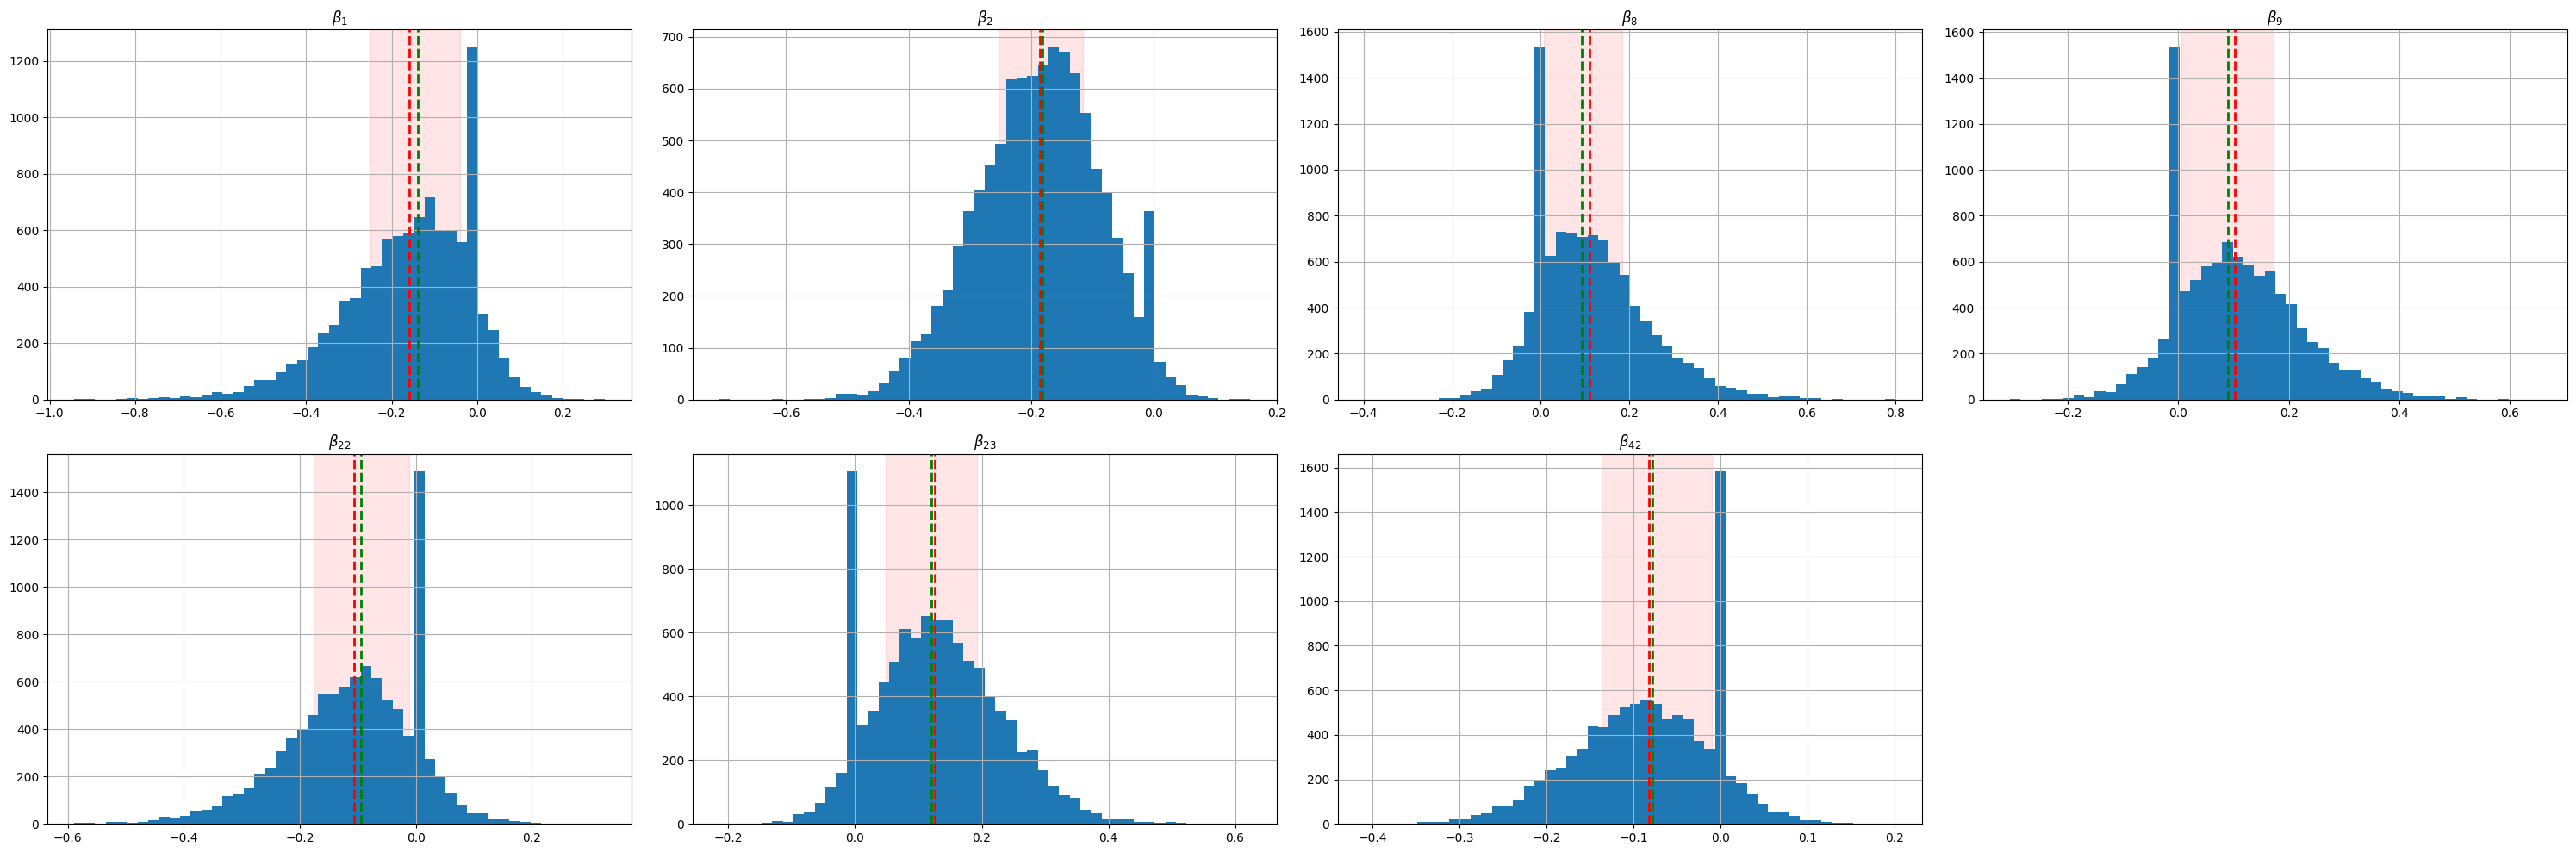

                Mean    Median
 gde1       0.125549  0.120520
 p65        0.110809  0.093192
 pm65       0.102322  0.090035
 pinstab1  -0.082078 -0.077691
 geerec1   -0.106403 -0.094797
 gdpsh465  -0.158794 -0.139517
 bmp1l     -0.185902 -0.181618


In [65]:
threshold = 0.25
selected_scaled = select_variables(betas_scaled, threshold = threshold)
medians_sc, means_sc = plotAll(betas_scaled[:, selected_scaled], num_rows=2, figsize=(30, 10), indexes = np.array(selected_scaled) + 1, threshold = threshold)
res_df_sc = pd.DataFrame(np.array([means_sc, medians_sc]).T, columns=["Mean", "Median"], index=data.columns[np.array(selected_scaled)])
print(res_df_sc.sort_values(by="Median", ascending=False))

In [54]:
#return index of "hf65" in data.columns
print(np.where(data.columns==" hf65 "))
data.columns

(array([6]),)


Index([' gdpsh465 ', ' bmp1l ', ' freeop ', ' freetar ', ' h65 ', ' hm65 ',
       ' hf65 ', ' p65 ', ' pm65 ', ' pf65 ', ' s65 ', ' sm65 ', ' sf65 ',
       ' fert65 ', ' mort65 ', ' lifee065 ', ' gpop1 ', ' fert1 ', ' mort1 ',
       ' invsh41 ', ' geetot1 ', ' geerec1 ', ' gde1 ', ' govwb1 ',
       ' govsh41 ', ' gvxdxe41 ', ' high65 ', ' highm65 ', ' highf65 ',
       ' highc65 ', ' highcm65 ', ' highcf65 ', ' human65 ', ' humanm65 ',
       ' humanf65 ', ' hyr65 ', ' hyrm65 ', ' hyrf65 ', ' no65 ', ' nom65 ',
       ' nof65 ', ' pinstab1 ', ' pop65 ', ' worker65 ', ' pop1565 ',
       ' pop6565 ', ' sec65 ', ' secm65 ', ' secf65 ', ' secc65 ', ' seccm65 ',
       ' seccf65 ', ' syr65 ', ' syrm65 ', ' syrf65 ', ' teapri65 ',
       ' teasec65 ', ' ex1 ', ' im1 ', ' xr65 ', ' tot1 ', 'Outcome'],
      dtype='object')

In [135]:
residuals = y_scaled[0].reshape((91, )) - X_scaled[0] @ np.median(betas_scaled, axis = 0)
R_sq = 1 - np.var(residuals) / np.var(y_scaled[0])
RMSE = np.sqrt(np.mean(np.square(residuals)))
R_sq

0.40309235692756407

In [130]:
lr = LinearRegression()
lr.fit(X_scaled[0][:, selected_scaled], y_scaled[0])
lr.score(X_scaled[0][:, selected_scaled], y_scaled[0])

0.3531140915787859

### Normalizer

dataset 0 :


100%|██████████| 1100/1100 [01:05<00:00, 16.84it/s]


Shape of betas:  (1000, 61)


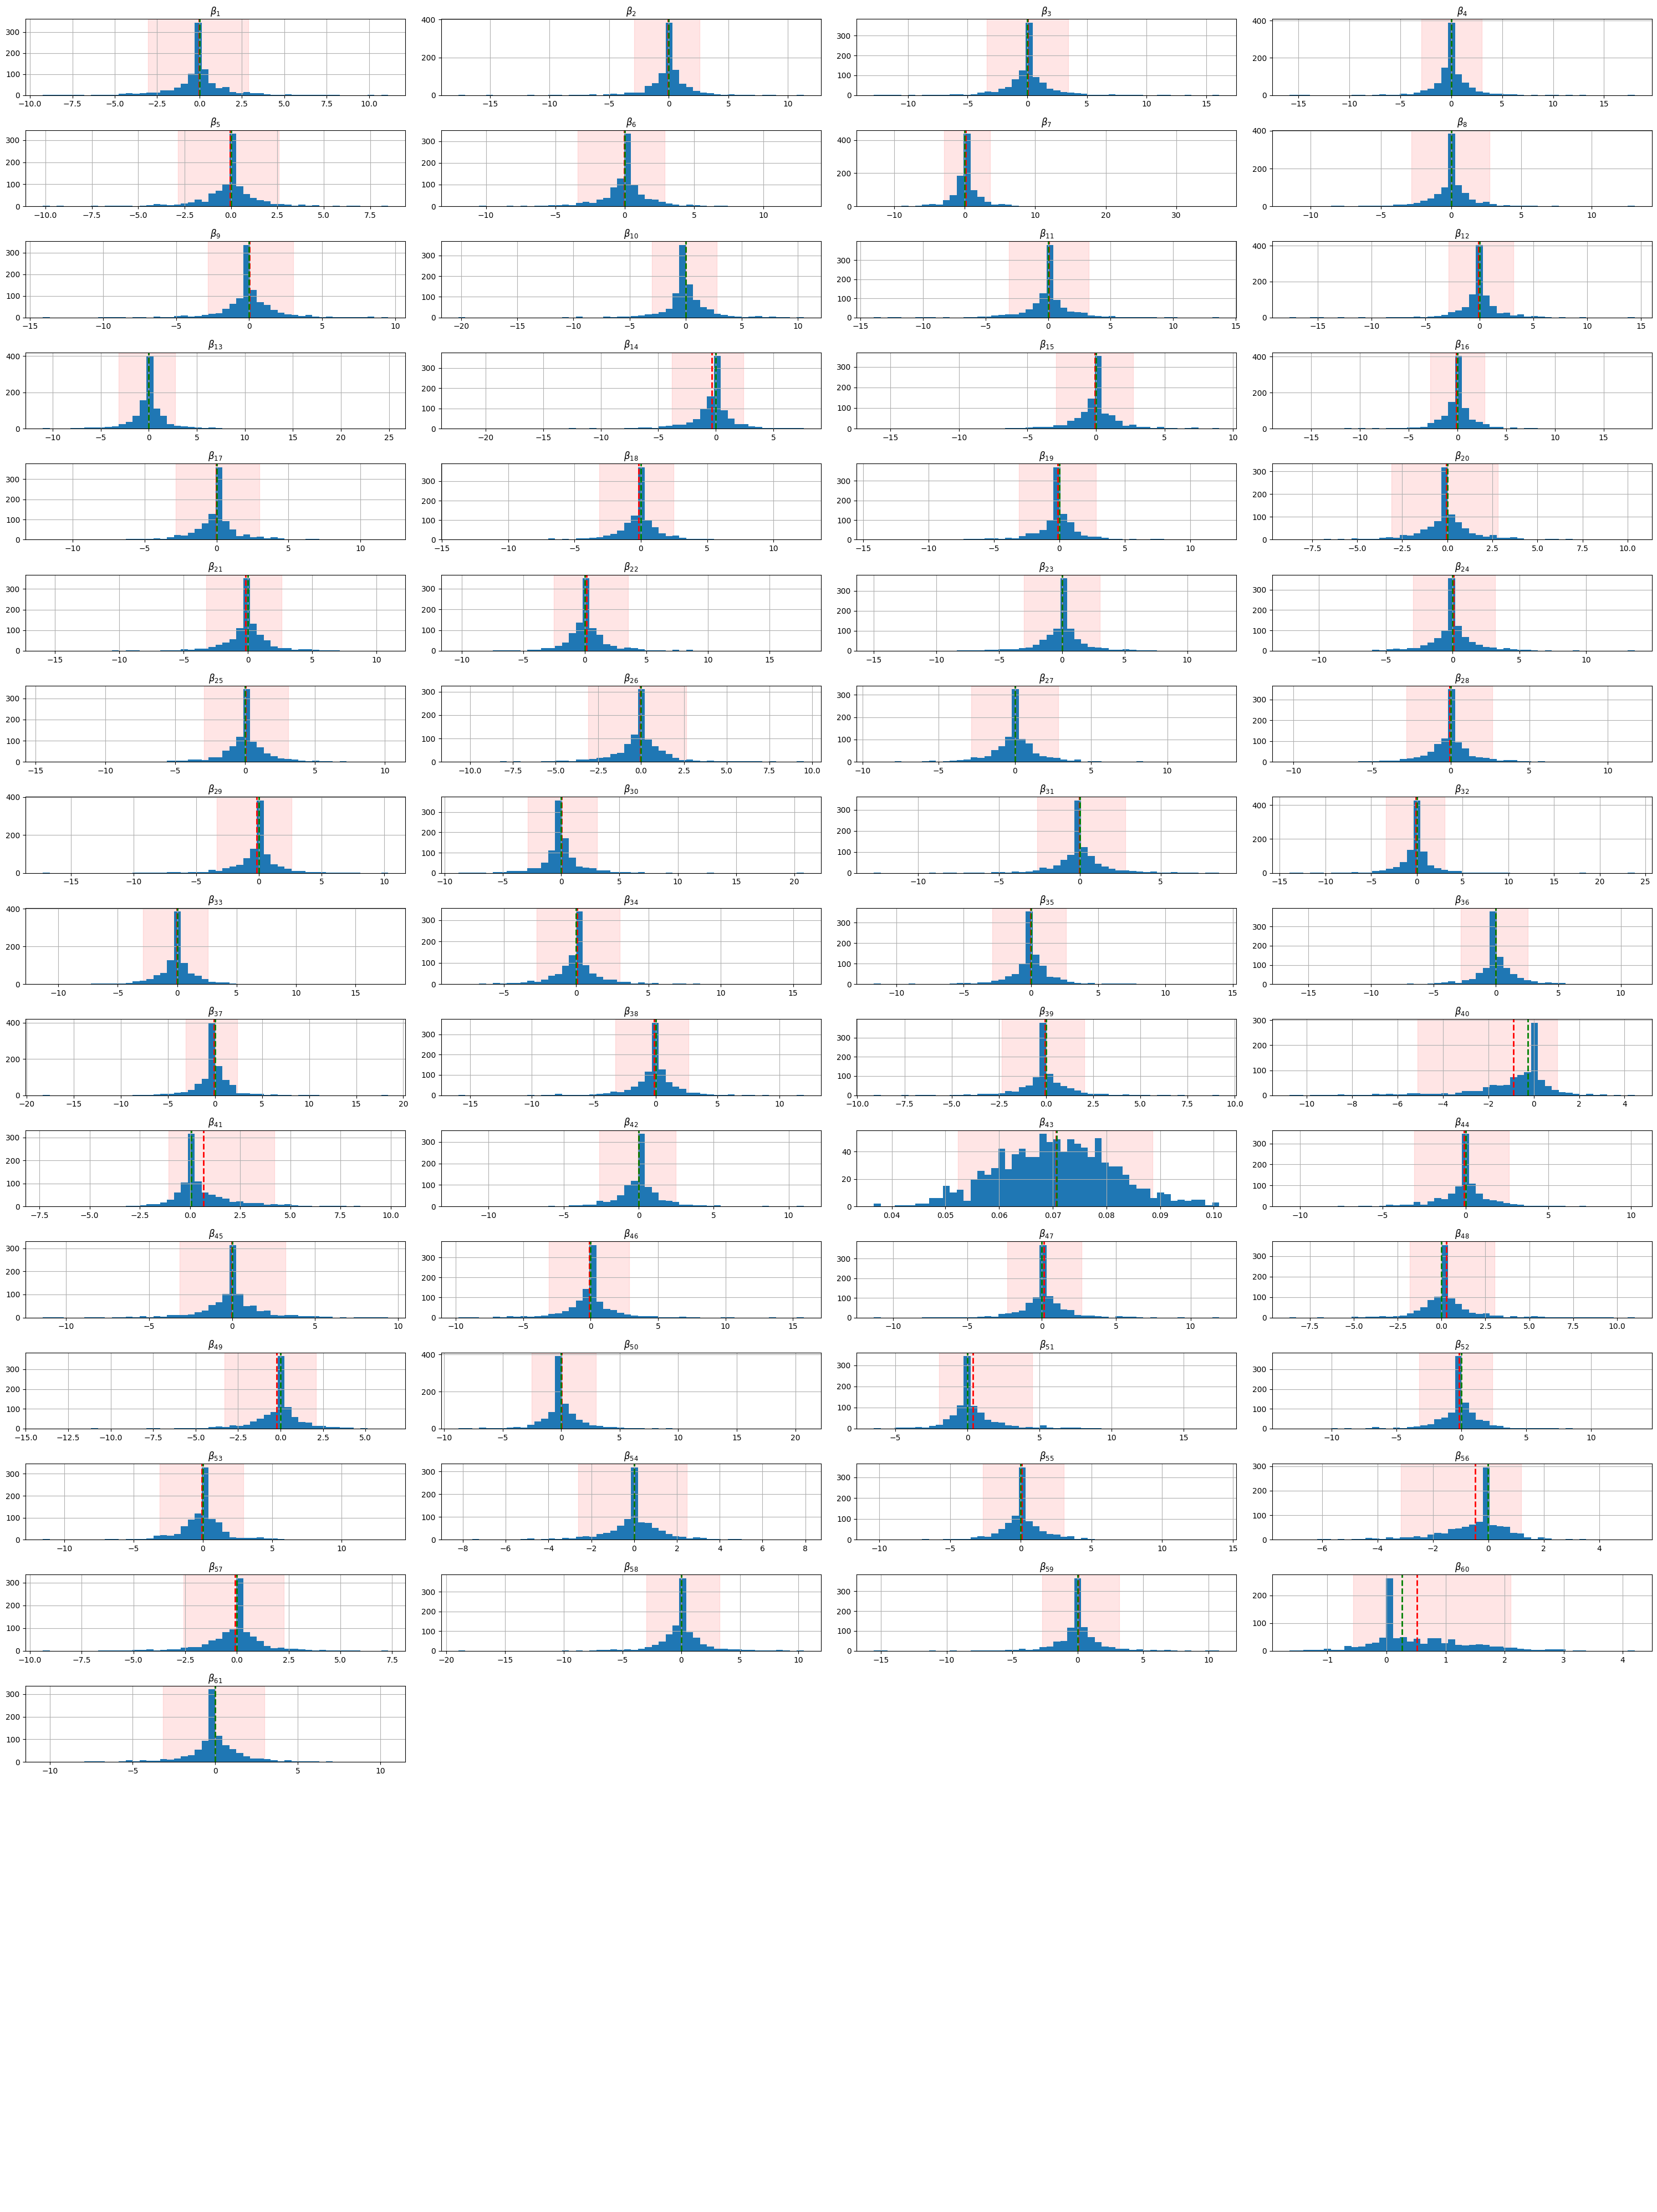

In [138]:
X_normalized=normalizer.fit_transform(X[0]).reshape(1,91,61)
y_normalized=y/np.linalg.norm(y)
betas,l_q=run(X_normalized, y_normalized, mesh, n_iterations, n_burnin, verbose = False)
betas_normalizer = np.array(betas[n_burnin:])
print("Shape of betas: ", betas_normalizer.shape) #Expected (10000, 61)
medians, means = plotAll(betas_normalizer)


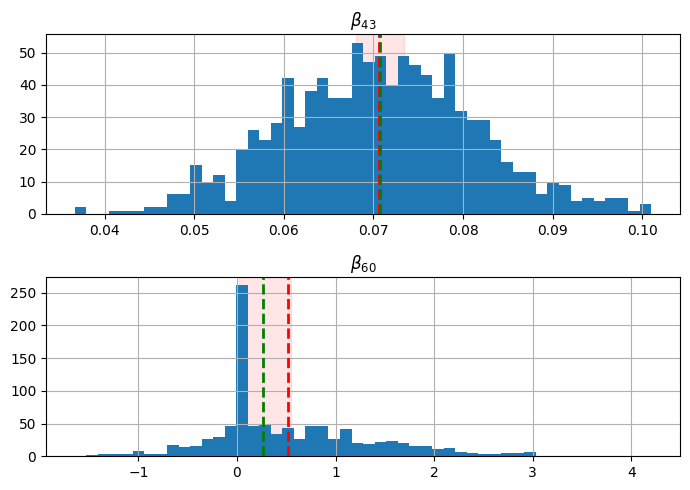

             Mean    Median
 xr65    0.518369  0.259307
 pop65   0.070632  0.070723


In [141]:
threshold = 0.4
selected_norm = select_variables(betas_normalizer, threshold = threshold)
medians, means = plotAll(betas_normalizer[:, selected_norm], num_rows=2, figsize=(7, 5), indexes = np.array(selected_norm) + 1, threshold = threshold)
res_df_norm = pd.DataFrame(np.array([means, medians]).T, columns=["Mean", "Median"], index=data.columns[np.array(selected_norm)])
print(res_df_norm.sort_values(by="Median", ascending=False))

In [140]:
residuals = y_normalized[0].reshape((91, )) - X_normalized[0] @ np.median(betas_normalizer, axis = 0)
R_sq = 1 - np.var(residuals) / np.var(y_normalized[0])
RMSE = np.sqrt(np.mean(np.square(residuals)))
R_sq

0.00822875718032201

### Min-Max

dataset 0 :


100%|██████████| 1100/1100 [01:14<00:00, 14.68it/s]


Shape of betas:  (1000, 61)


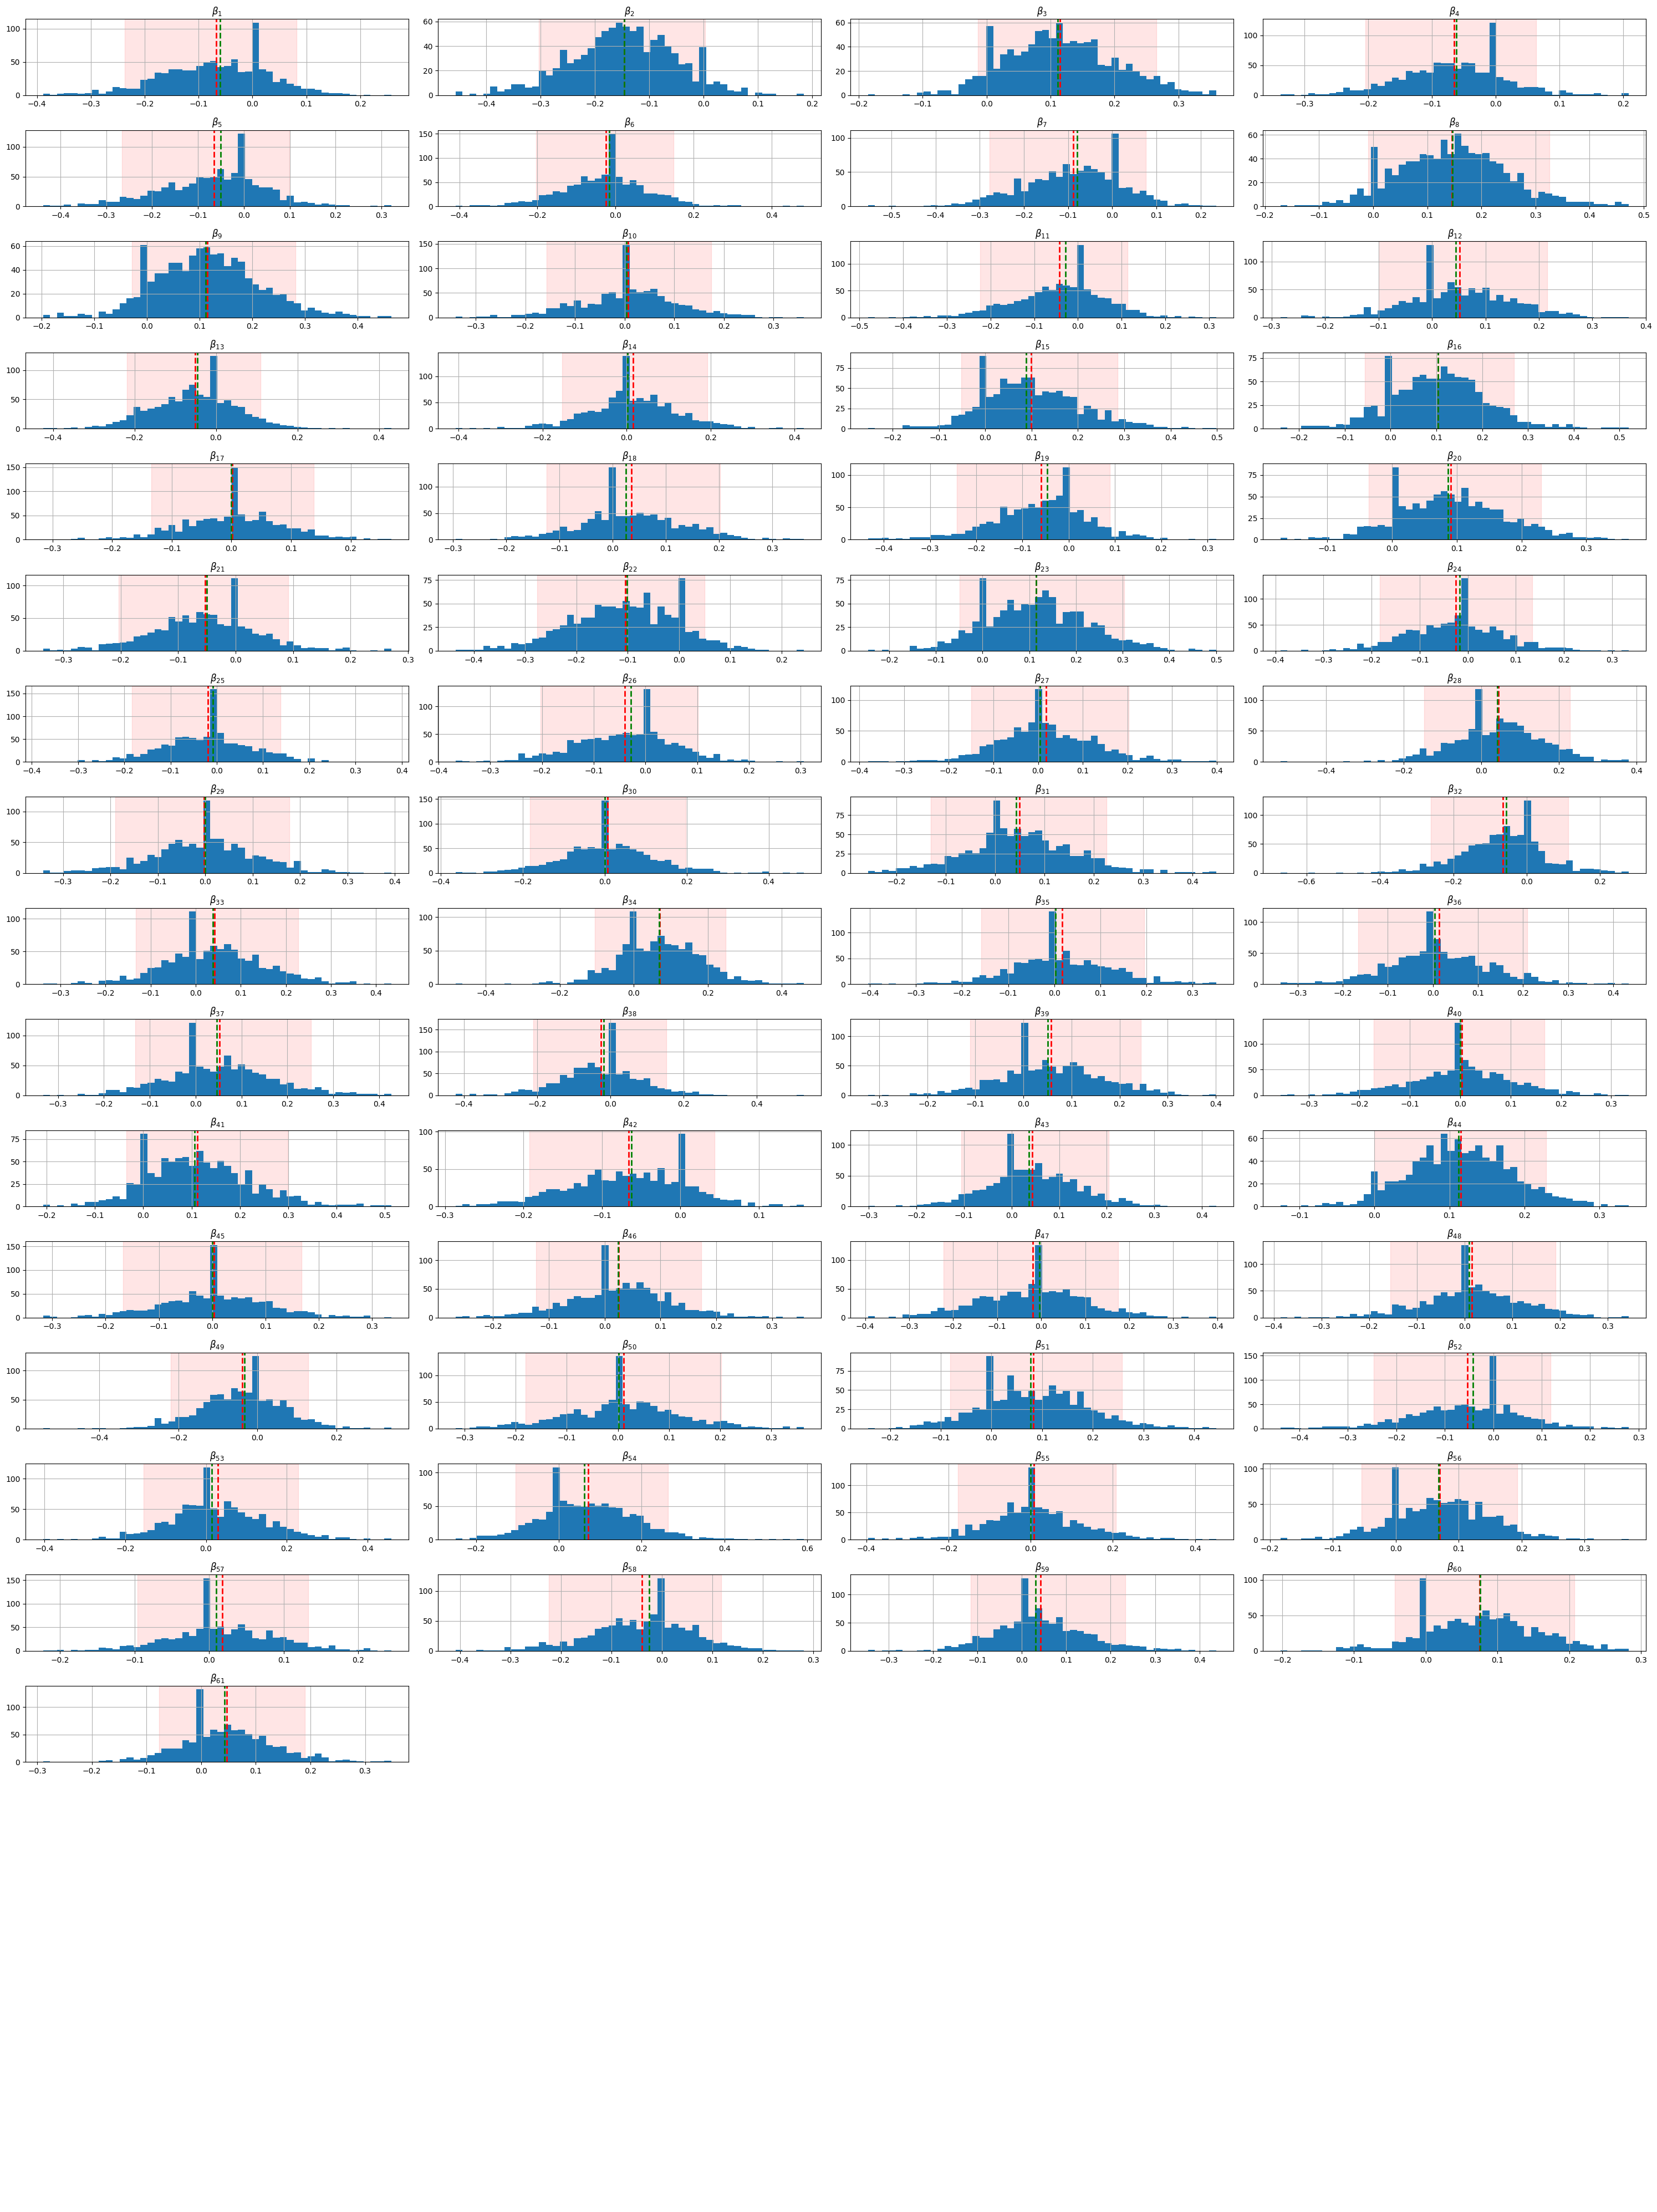

In [142]:
X_minmax=minmax.fit_transform(X[0]).reshape(1,91,61)
y_minmax=(y-np.min(y))/(np.max(y)-np.min(y))
betas,l_q=run(X_minmax, y_minmax, mesh, n_iterations, n_burnin, verbose = False)
betas_minmax = np.array(betas[n_burnin:])
print("Shape of betas: ", betas_minmax.shape) #Expected (10000, 61)
medians, means = plotAll(betas_minmax)


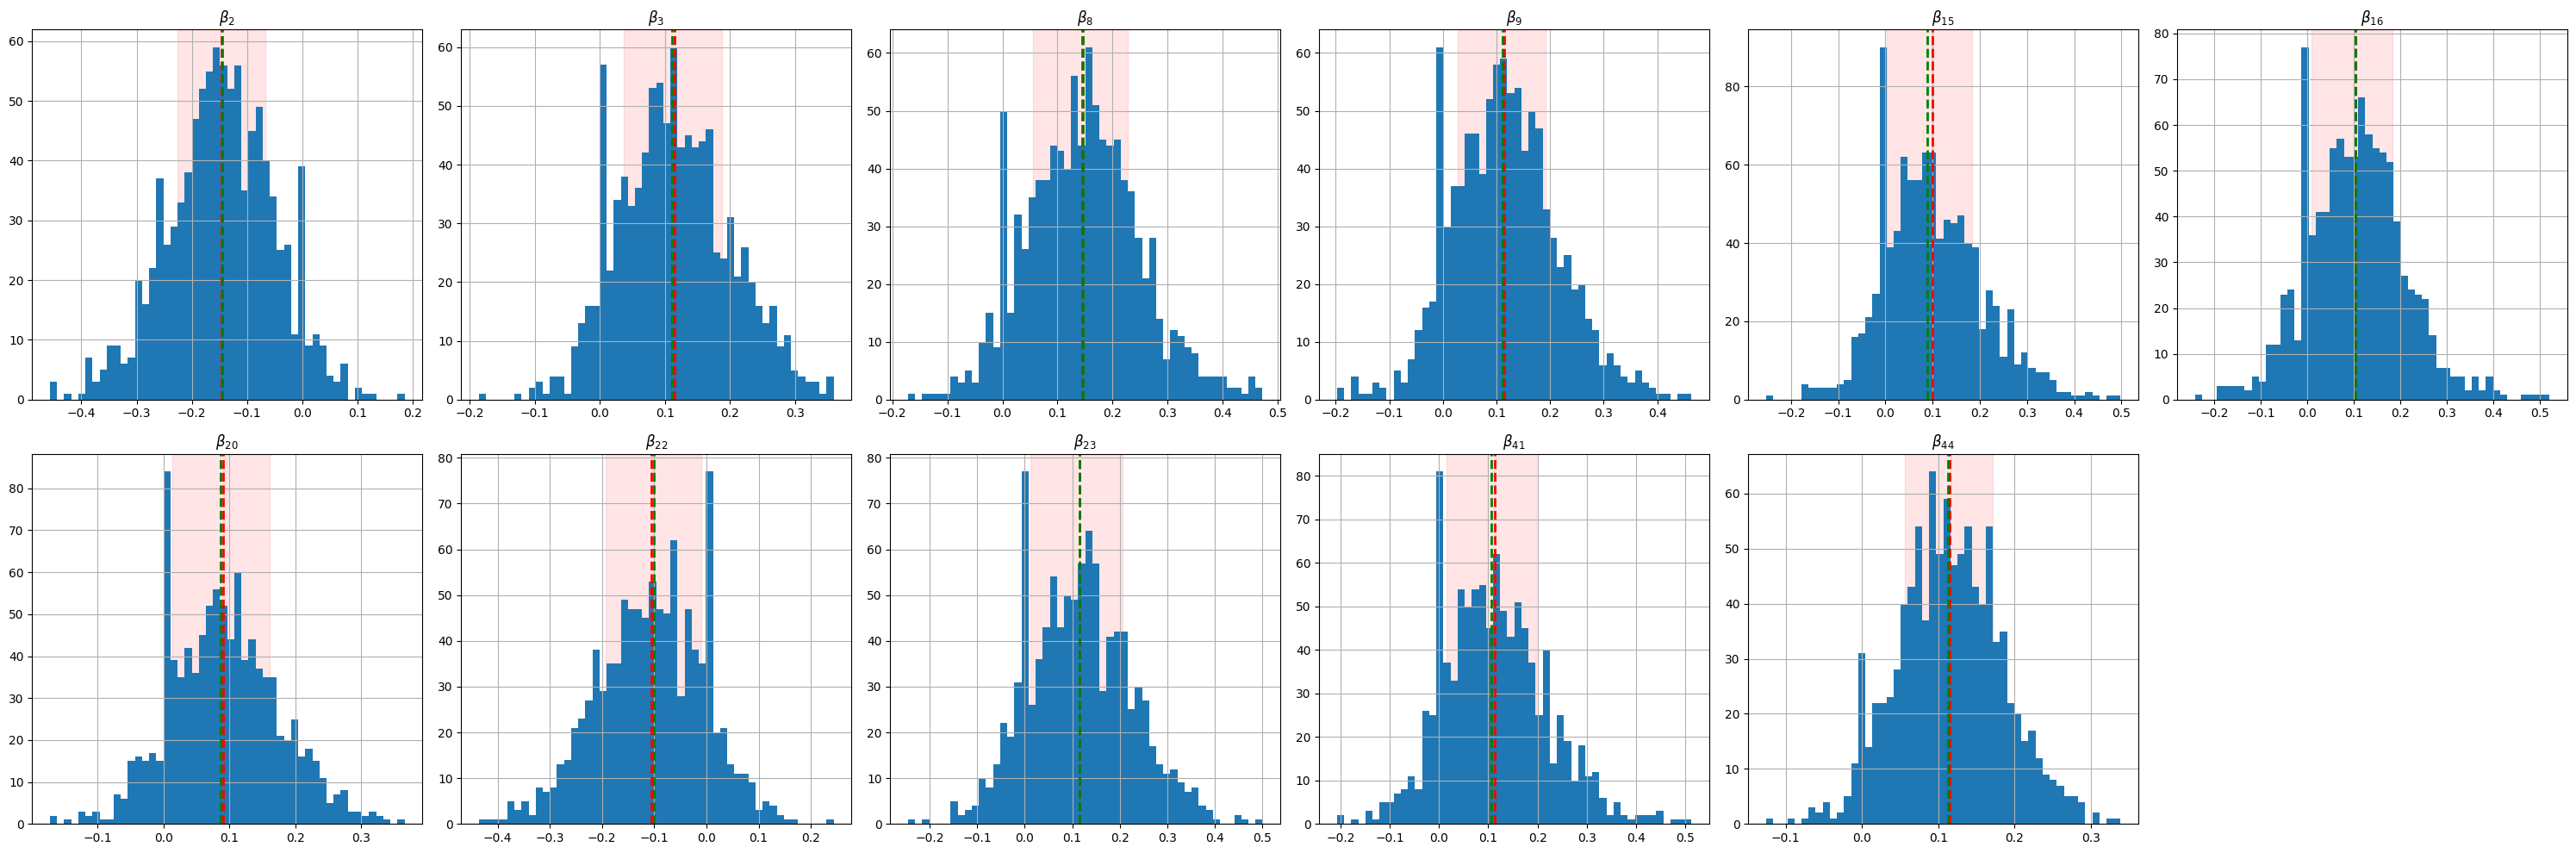

                Mean    Median
 p65        0.145193  0.146354
 gde1       0.114621  0.114437
 worker65   0.114788  0.112522
 freeop     0.114446  0.111438
 pm65       0.114392  0.111272
 nof65      0.112412  0.106632
 lifee065   0.103229  0.103726
 mort65     0.098808  0.087871
 invsh41    0.090561  0.086743
 geerec1   -0.104958 -0.101117
 bmp1l     -0.145832 -0.145596


In [143]:
threshold = 0.2
selected_minmax = select_variables(betas_minmax, threshold)
medians, means = plotAll(betas_minmax[:, selected_minmax], num_rows=2, figsize=(30, 10), indexes =  np.array(selected_minmax) + 1, threshold=threshold)
res_df_minmax = pd.DataFrame(np.array([means, medians]).T, columns=["Mean", "Median"], index=data.columns[np.array(selected_minmax)])
print(res_df_minmax.sort_values(by="Median", ascending=False))

In [145]:
residuals = y_minmax[0].reshape((91, )) - X_minmax[0] @ np.mean(betas_minmax, axis = 0)
R_sq = 1 - np.var(residuals) / np.var(y_minmax[0])
RMSE = np.sqrt(np.mean(np.square(residuals)))
R_sq

0.4516185770291784